# Working with Bar Data

In [306]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import scipy.stats as st


from candlestick.candlestick import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from getstock import *

matplotlib.rcParams['figure.figsize'] = (14, 6)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data and format it

In [263]:
df_ohlc = pd.read_csv('DAT_MT_USDTRY_M1_201909.csv')
df_ohlc.index = pd.to_datetime(df_ohlc.day)+ pd.to_timedelta(df_ohlc.time.apply(lambda x:x+':00'),unit='minute')
df_ohlc = df_ohlc[['open','high','low','close']]

#### Plot Candlestick chart for a short time

In [265]:
df_to_plot = df_ohlc.iloc[:800]
fig = go.Figure(data=[go.Candlestick(x=df_to_plot.index,
                open=df_to_plot['open'],
                high=df_to_plot['high'],
                low=df_to_plot['low'],
                close=df_to_plot['close'])])
fig.show()

#### Define Functions to:
+ Label intervals with returns
+ Detect patterns
+ Make statistics on them

In [304]:
def label(df_candles,n_shift):
    """
    label returns n_shift periods before them
    """
    df_candles['returns'+str(n_shift)] = df_candles['close'].shift(-n_shift)/df_candles['close']
    return df_candles

def get_candlestick_detection_function(pattern):
    return getattr(getattr(__import__('candlestick.candlestick'), 'candlestick'),pattern)

def detect_patterns(patterns_list,df_bars):
    df_bars = df_bars.copy()
    for p in patterns_list:
        func = get_candlestick_detection_function(p)
        df_bars = func(df_bars)
    return df_bars
def make_stats(patterns_list,df_bars,returns_name):
    df = pd.DataFrame(index=['mean','CI','count','std'])
    ret = (df_bars[returns_name]-1.)*100
    for p in patterns_list:
        p_list = p.split('_')
        p_modified = ''.join(list(map(lambda x: x[0].upper()+x[1:],p_list)))
        ret_pattern = ret[df_bars[p_modified]==True]
        mean= ret_pattern.mean()
        std = ret_pattern.std()
        count = ret_pattern.count()
        CI = std*st.t.ppf(0.975,count)/np.sqrt(count)
        df[p_modified] = [mean,CI,count,std]
    return df 

def label_multi(n_shift_list,df_bars):
    df_bars = df_bars.copy()
    for n in n_shift_list:
        df_bars = label(df_bars,n)
    return df_bars


### Find the list of supported patterns

In [267]:
patterns_list = list(map(lambda x :x.replace('.py',''), os.listdir('candlestick/patterns')))
patterns_list.remove('candlestick_finder')
patterns_list.remove('__pycache__')
patterns_list

['bearish_engulfing',
 'bearish_harami',
 'bullish_engulfing',
 'bullish_harami',
 'dark_cloud_cover',
 'doji',
 'doji_star',
 'dragonfly_doji',
 'evening_star',
 'evening_star_doji',
 'gravestone_doji',
 'hammer',
 'hanging_man',
 'inverted_hammer',
 'morning_star',
 'morning_star_doji',
 'piercing_pattern',
 'rain_drop',
 'rain_drop_doji',
 'shooting_star',
 'star']

#### Run all patterns detection

In [270]:
df_bars = detect_patterns(patterns_list,df)

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\doji.py:17: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\doji_star.py:25: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\dragonfly_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\evening_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\gravestone_doji.py:16: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candlestick\patterns\morning_star_doji.py:30: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\elior illouz\Notebooks\Algo Trading\project\candles

#### Label returns for different shifts

In [271]:
df_bars = label_multi([1,2,3,4,5,8,10,20,30],df_bars)

In [272]:
df_bars

,open,high,low,close,BearishEngulfing,BearishHarami,BullishEngulfing,BullishHarami,DarkCloudCover,Doji,...,Star,returns1,returns2,returns3,returns4,returns5,returns8,returns10,returns20,returns30
2019-09-01 17:01:00,5.83330,5.83331,5.83330,5.83331,None,None,None,None,None,False,...,None,0.999998,0.999998,1.000000,0.999998,0.999998,1.000000,0.999998,0.999998,0.999998
2019-09-01 17:02:00,5.83330,5.83330,5.83330,5.83330,False,False,False,False,False,False,...,False,1.000000,1.000002,1.000000,1.000000,1.000002,1.000000,1.000002,1.000002,1.000000
2019-09-01 17:03:00,5.83331,5.83331,5.83330,5.83330,False,False,False,False,False,False,...,False,1.000002,1.000000,1.000000,1.000002,1.000000,1.000000,1.000000,1.000000,1.000002
2019-09-01 17:04:00,5.83331,5.83331,5.83331,5.83331,False,False,False,False,False,False,...,False,0.999998,0.999998,1.000000,0.999998,1.000000,1.000000,0.999998,1.000000,1.000000
2019-09-01 17:05:00,5.83330,5.83330,5.83330,5.83330,False,False,False,False,False,False,...,False,1.000000,1.000002,1.000000,1.000002,1.000000,1.000000,1.000000,1.000002,1.000000
2019-09-01 17:06:00,5.83331,5.83331,5.83330,5.83330,False,False,False,False,False,False,...,False,1.000002,1.000000,1.000002,1.000000,1.000000,1.000000,1.000002,1.000000,1.000002
2019-09-01 17:07:00,5.83331,5.83331,5.83331,5.83331,False,False,False,False,False,False,...,False,0.999998,1.000000,0.999998,0.999998,1.000000,0.999998,0.999998,1.000000,1.000000
2019-09-01 17:08:00,5.83330,5.83330,5.83330,5.83330,False,False,False,False,False,False,...,False,1.000002,1.000000,1.000000,1.000002,1.000000,1.000002,1.000002,1.000002,1.000002
2019-09-01 17:09:00,5.83331,5.83331,5.83331,5.83331,False,False,False,False,False,False,...,False,0.999998,0.999998,1.000000,0.999998,0.999998,0.999998,1.000000,0.999998,1.000000
2019-09-01 17:10:00,5.83330,5.83331,5.83330,5.83330,False,False,False,False,False,False,...,False,1.000000,1.000002,1.000000,1.000000,1.000000,1.000002,1.000000,1.000002,1.000000


#### Statistics on the returns based on the candlestick pattern

In [305]:
df = make_stats(patterns_list,df_bars,'returns5')
df.T

,mean,CI,count,std
BearishEngulfing,-0.000043,0.002073,1763.0,0.044375
BearishHarami,-0.000238,0.002042,1904.0,0.045433
BullishEngulfing,-0.001919,0.002166,1624.0,0.044512
BullishHarami,-0.000607,0.001976,1916.0,0.044104
DarkCloudCover,0.005063,0.013814,24.0,0.032788
Doji,-0.000244,0.002054,1473.0,0.040196
DojiStar,-0.002609,0.009048,68.0,0.037393
DragonflyDoji,-0.000895,0.003077,487.0,0.034563
EveningStar,-0.003626,0.003848,145.0,0.023446
EveningStarDoji,-0.000271,0.028609,2.0,0.009403


#### Visualize the distribution of the returns for a specific pattern 

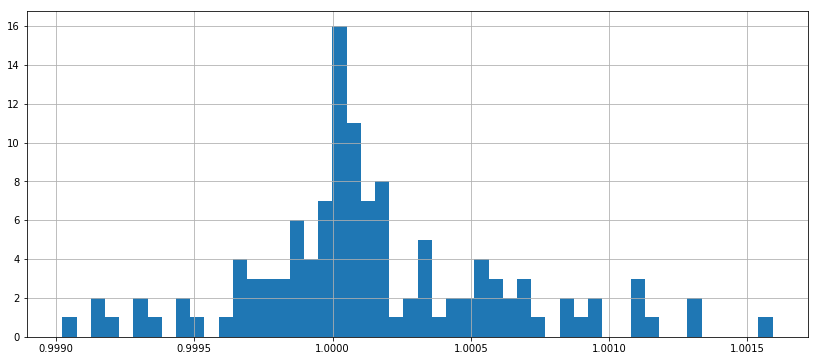

In [289]:
df_bars['returns5'][df_bars['InvertedHammer']==True].hist(bins=50)

#### Resample to larger windows

In [ ]:
df_bars = df_bars.resample('2min').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})


## Other way of getting data

First let's take a look at [getstock.py](getstock.py)...

In [130]:
# now let's get some data
# bars = getMinuteFXPrices('EURGBP')
bars = getMinuteStockPrices('EURUSD')